# Make artificial linear dataset for ANN training

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot

cc = np.concatenate


TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

BASES = ['rc', 'rect']
NH = 17  # num filter basis functions

COLS_USE = [f'S_{ch}' for ch in range(NH)] + [f'P_{ch}' for ch in range(NH)]

PTRAIN = .8
NSPLIT = 30

ALPHA = 10

NSPLIT_SAVE_Y_HAT = 5

MASK_PFX = 'data/simple/masks/mask'

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}_ridge_alpha_{ALPHA}'

In [2]:
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

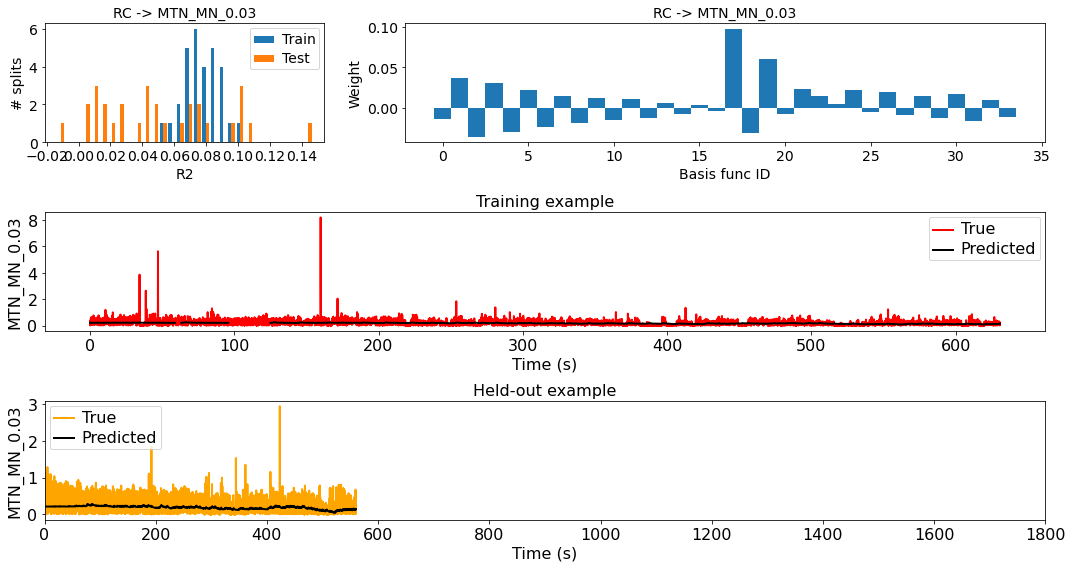

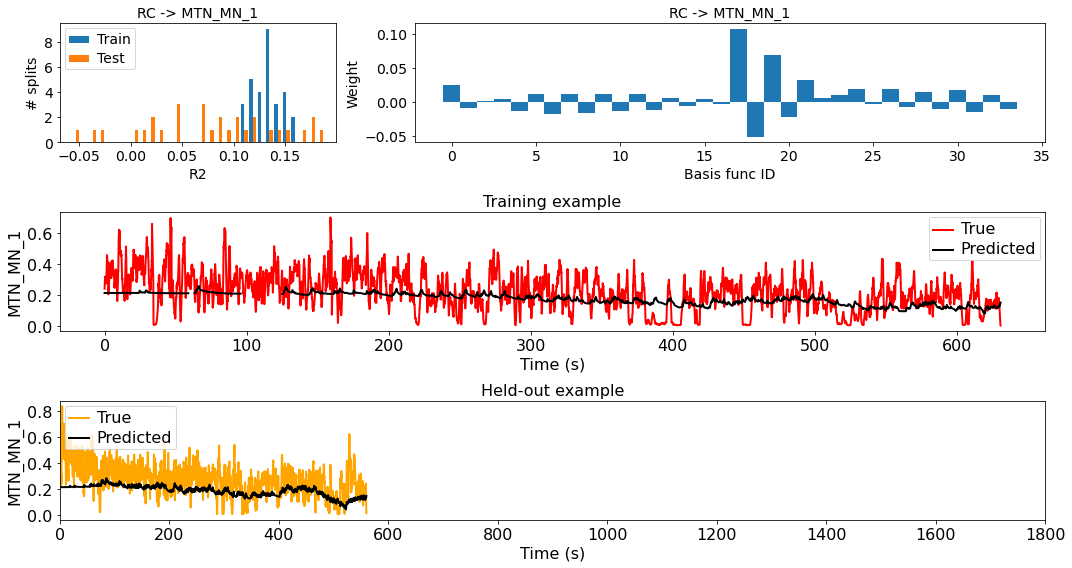

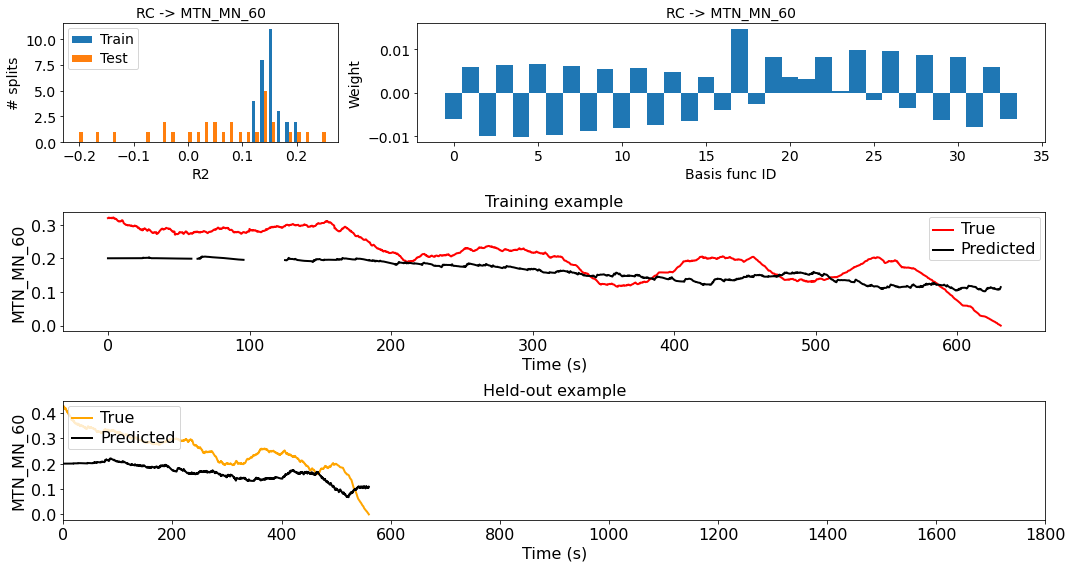

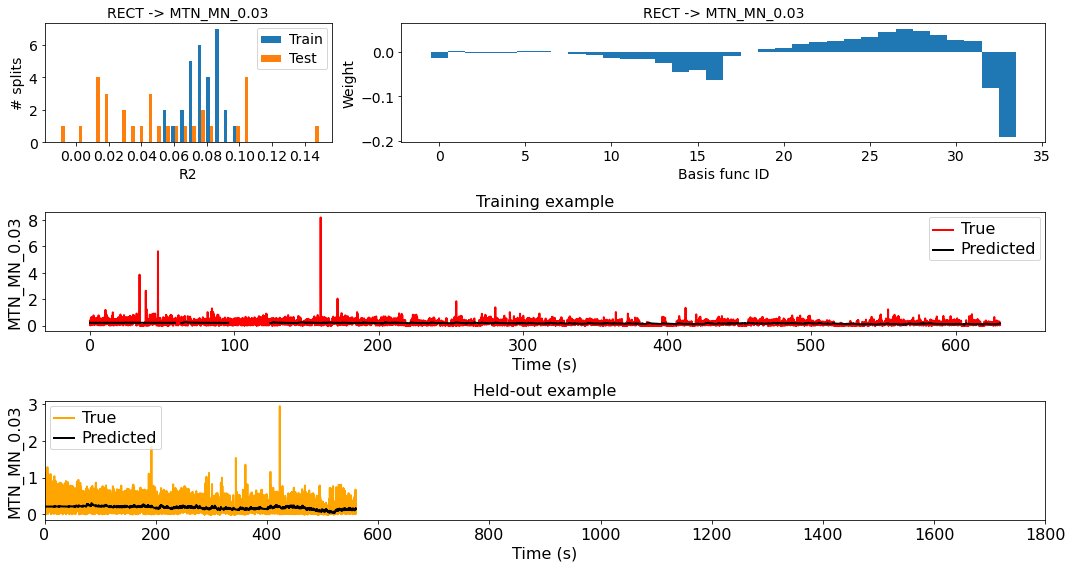

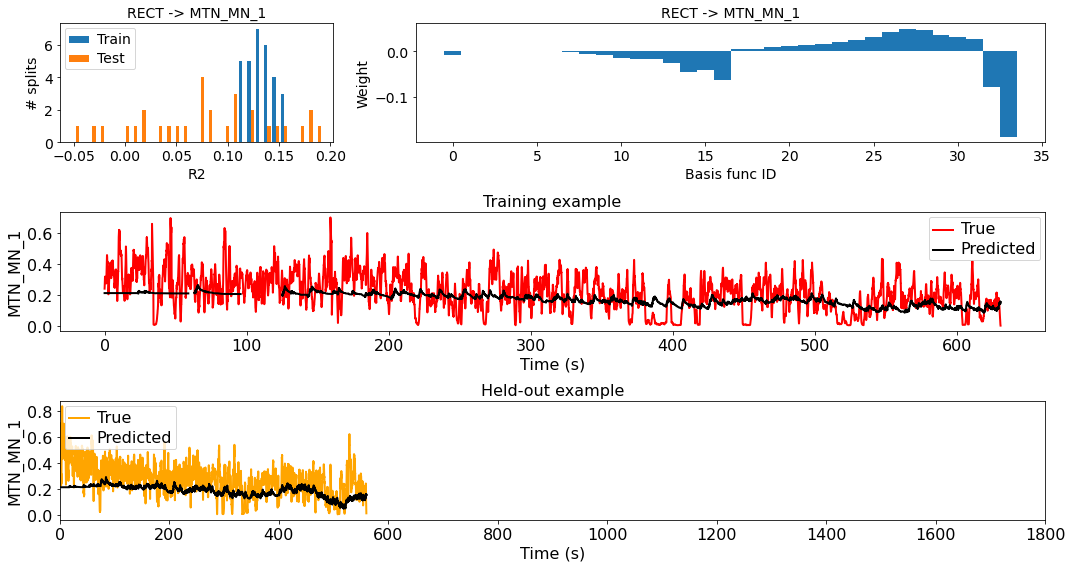

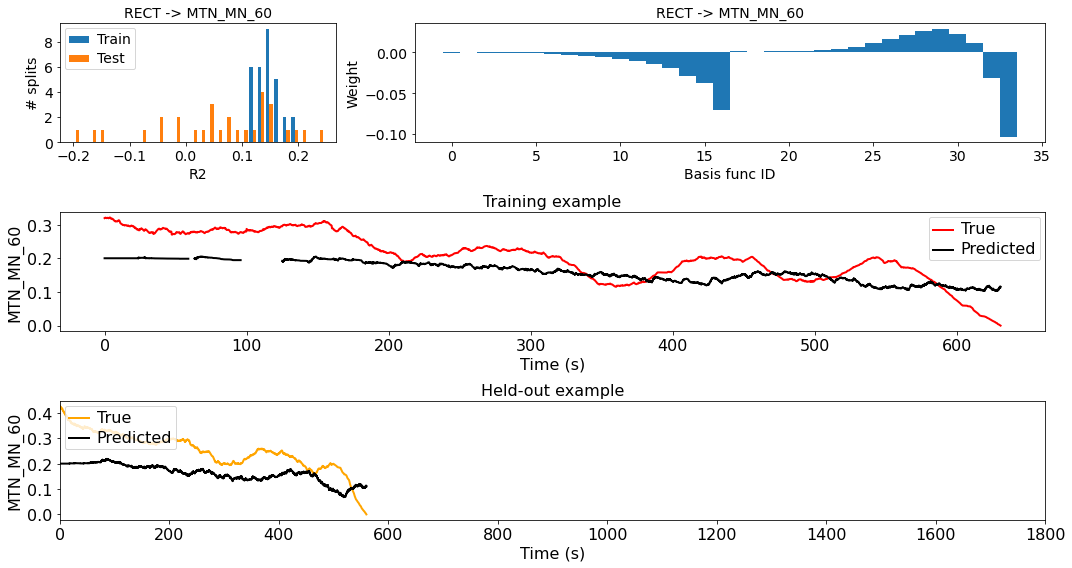

In [3]:
ISPLIT = 0
ITRAIN_PLOT = 1
ITEST_PLOT = 1

FPS = 30.03

for basis in BASES:
    fsave = f'data/simple/mlv/lin_filter/{basis}_lin_{STRAIN_KEY}_{FSAVE_SFX}.npy'
    
    data = np.load(fsave, allow_pickle=True)[0]

    for targ in TARGS:
        
        r2_train = data['r2_train'][targ]
        r2_test = data['r2_test'][targ]
        
        gs = gridspec.GridSpec(3, 3)

        fig = plt.figure(figsize=(15, 8), tight_layout=True)
        axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :]), fig.add_subplot(gs[2, :])]

        axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
        axs[0].legend(['Train', 'Test'])
        
        set_plot(axs[0], x_label='R2', y_label='# splits', title=f'{basis.upper()} -> {targ}', font_size=14)

        axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
        set_plot(axs[1], x_label='Basis func ID', y_label='Weight', title=f'{basis.upper()} -> {targ}', font_size=14)

        y_train = data['ys_train'][targ][ISPLIT][ITRAIN_PLOT]
        t_train = np.arange(len(y_train))/FPS
        
        y_hat_train = data['y_hats_train'][targ][ISPLIT][ITRAIN_PLOT]
        
        axs[2].plot(t_train, y_train, c='r', lw=2)
        axs[2].plot(t_train, y_hat_train, c='k', lw=2)
        
        axs[2].legend(['True', 'Predicted'])
        
        set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

        y_test = data['ys_test'][targ][ISPLIT][ITEST_PLOT]
        t_test = np.arange(len(y_test))/FPS
        
        y_hat_test = data['y_hats_test'][targ][ISPLIT][ITEST_PLOT]
        
        axs[3].plot(t_test, y_test, c='orange', lw=2)
        axs[3].plot(t_test, y_hat_test, c='k', lw=2)
        
        axs[3].legend(['True', 'Predicted'], loc='upper left')
        
        set_plot(axs[3], x_lim=(0, 1800), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)

# Show filter reconstructions

In [4]:
FPS = 30.03
DT = 1/FPS
MAX_T = 120  # max look-back window
T_H = np.arange(0, MAX_T, DT)

17 filters


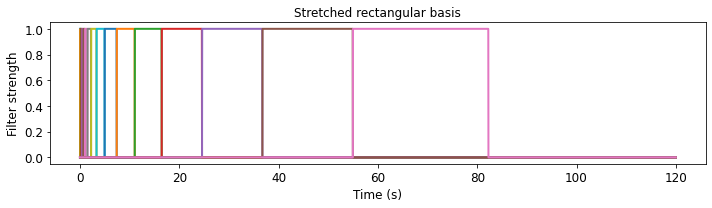

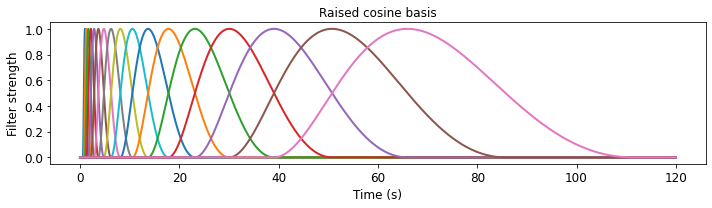

In [5]:
NDT_0 = 1  # width of closest filter
STRETCH = 1.5  # stretch factor relative to distance
hs_rect = []

istart = 0
istop = 0
ndt = NDT_0
while (istart+ndt)*DT < MAX_T:
    
    h_rect = np.zeros(T_H.shape)
    h_rect[istart:istart+ndt] = 1/(ndt*DT)
    hs_rect.append(h_rect.copy())
    
    istart = istart+ndt+1
    ndt = int(round(STRETCH*ndt))
    
hs_rect = np.array(hs_rect)

fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rect in hs_rect:
    ax.plot(T_H, h_rect/h_rect.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Stretched rectangular basis', font_size=12)
print(f'{len(hs_rect)} filters')

hs_rc = []
a = 6
c = 0
phis = np.arange(len(hs_rect)) * np.pi/2

for ch, phi in enumerate(phis):
    h_rc = .5*np.cos(a*np.log(T_H + c) - phi) + .5
    mt_zero = (a*np.log(T_H + c) < (phi-np.pi)) | (a*np.log(T_H + c) >= (phi+np.pi))
    h_rc[mt_zero] = 0
    hs_rc.append(h_rc)
    
hs_rc = np.array(hs_rc)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rc in hs_rc:
    ax.plot(T_H, h_rc/h_rc.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Raised cosine basis', font_size=12)

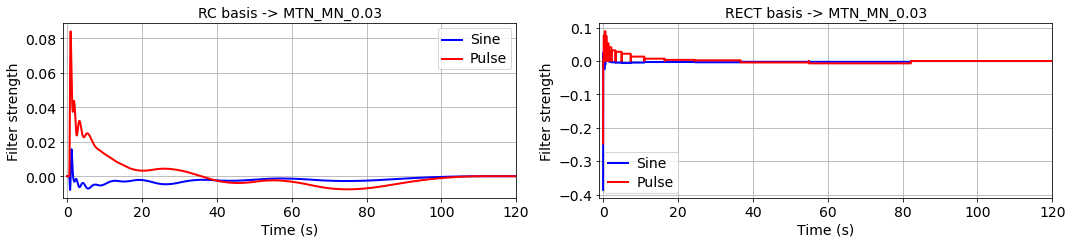

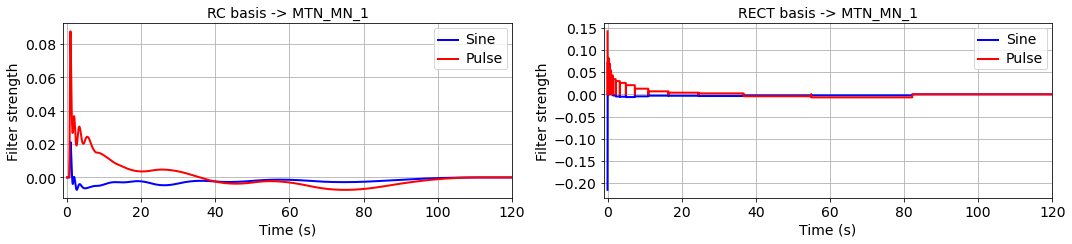

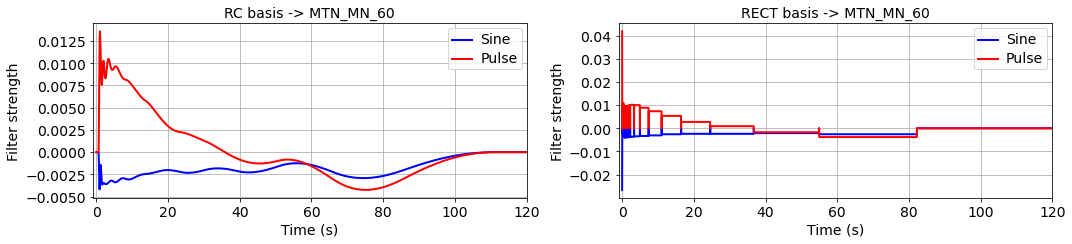

In [6]:
h_s_rc_mns = []
h_p_rc_mns = []
bias_mns = []

for twdw in TWDWS:
    targ = f'{TARG_BHV}_MN_{twdw}'
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 3.5), tight_layout=True)

    for ax, basis in zip(axs, BASES):
        fsave = f'data/simple/mlv/lin_filter/{basis}_lin_{STRAIN_KEY}_{FSAVE_SFX}.npy'
        data = np.load(fsave, allow_pickle=True)[0]
        
        if basis == 'rect':
            hs = hs_rect
        elif basis == 'rc':
            hs = hs_rc

        # sine filter
        w_s = data['w'][targ].mean(0)[:len(hs)]
        h_s = w_s@hs
        
        # pulse filter
        w_p = data['w'][targ].mean(0)[len(hs):]
        h_p = w_p@hs
        
        if basis == 'rc':
            h_s_rc_mns.append(h_s.copy())
            h_p_rc_mns.append(h_p.copy())
            
            bias_mns.append(data['bias'][targ].mean())

        ax.plot(T_H, h_s, c='b', lw=2)
        ax.plot(T_H, h_p, c='r', lw=2)

        ax.set_xlim(-1, 120)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Filter strength')
        ax.legend(['Sine', 'Pulse'])
        
        ax.grid()
        
        set_plot(ax, title=f'{basis.upper()} basis -> {targ}', font_size=14)

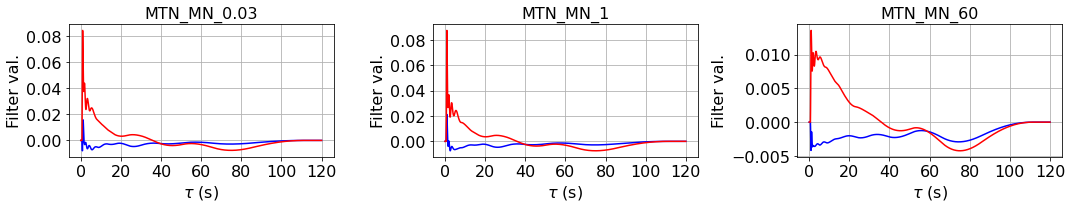

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3), tight_layout=True)
for ax, targ, h_s_rc_mn, h_p_rc_mn, in zip(axs, TARGS, h_s_rc_mns, h_p_rc_mns):
    ax.plot(T_H, h_s_rc_mn, c='b')
    ax.plot(T_H, h_p_rc_mn, c='r')
    ax.grid()
    set_plot(ax, x_label=r'$\tau$ (s)', y_label='Filter val.', title=targ, font_size=16)

# Generate artificial data

In [8]:
# load songs
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [9]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
df_trs = [df_behav[df_behav.ID == i] for i in range(n_tr)]
df_behav = None

In [10]:
from scipy.signal import fftconvolve

df_tr_lins = []
for df_tr in df_trs:
    i_s = np.array((df_tr['S']==1), dtype=float)
    i_p = np.array((df_tr['P']==1)|(df_tr['F']==1), dtype=float)
    
    data_tr = {'ID': np.array(df_tr['ID']), 'FRAME': df_tr['FRAME'], 'T': np.array(df_tr['T']), 'S': i_s, 'P': i_p}
    
    for targ, h_s_rc_mn, h_p_rc_mn, bias_mn in zip(TARGS, h_s_rc_mns, h_p_rc_mns, bias_mns):
        data_tr[targ] = fftconvolve(i_s, h_s_rc_mn)[:len(i_s)] + fftconvolve(i_p, h_p_rc_mn)[:len(i_p)] + bias_mn
        
    df_tr_lin = pd.DataFrame(columns=(['ID', 'FRAME', 'T', 'S', 'P'] + TARGS), data=data_tr)
    df_tr_lins.append(df_tr_lin)

In [11]:
df_full_lin = pd.concat(df_tr_lins)
df_full_lin.to_csv('data/simple/ann/c_song_f_behav_lin.csv', index=False)

# Reload and plot examples

In [12]:
df_behav_lin = pd.read_csv('data/simple/ann/c_song_f_behav_lin.csv')

In [13]:
n_tr = np.max(df_behav_lin.ID) + 1
df_tr_lins = [df_behav_lin[df_behav_lin.ID == i] for i in range(n_tr)]
df_behav_lin = None

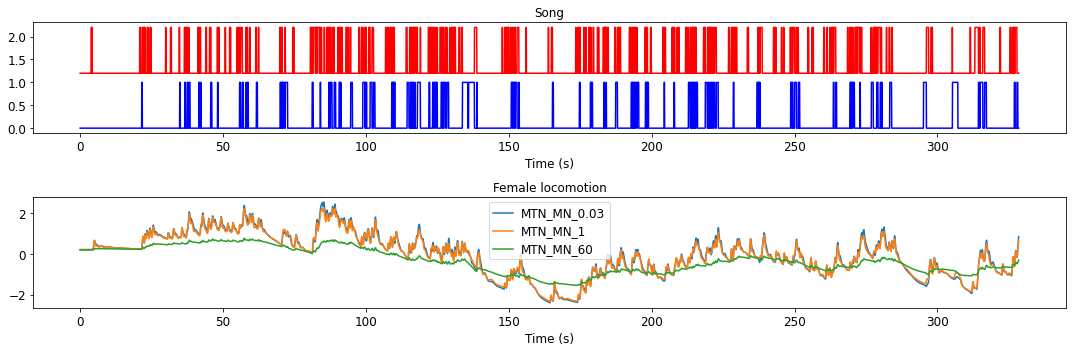

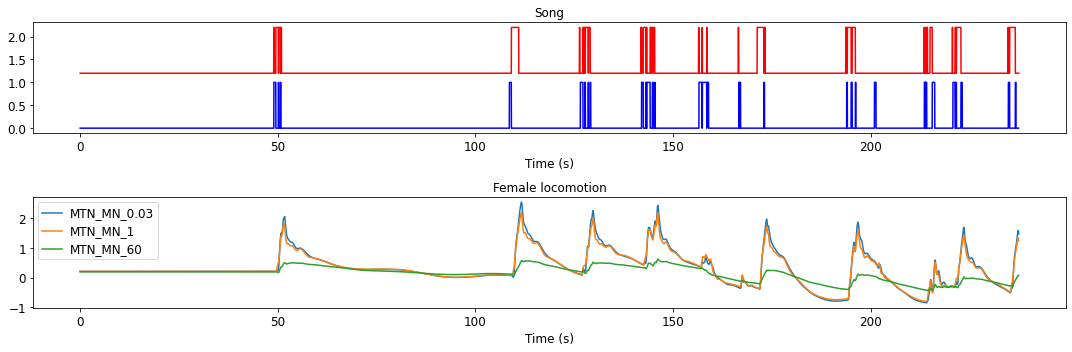

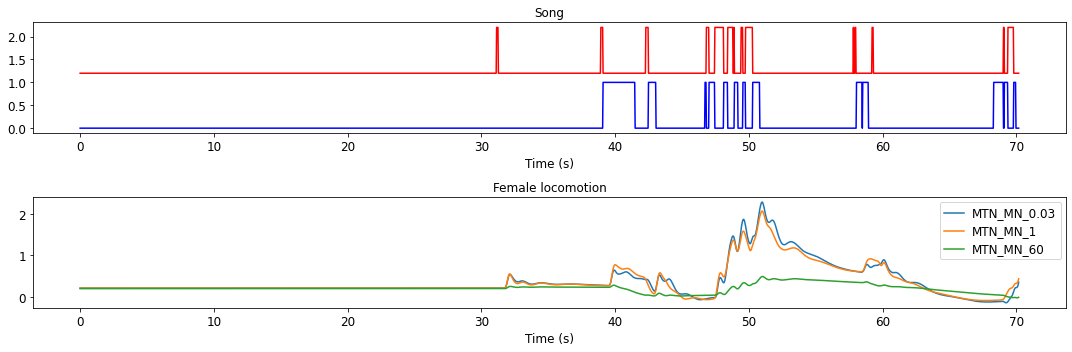

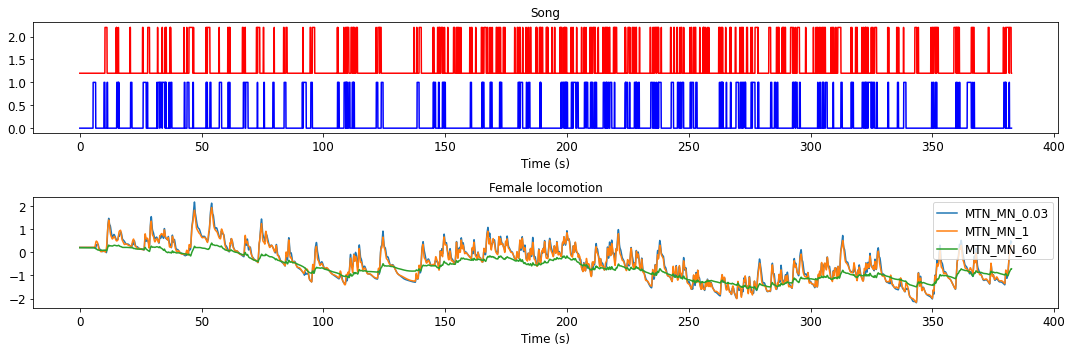

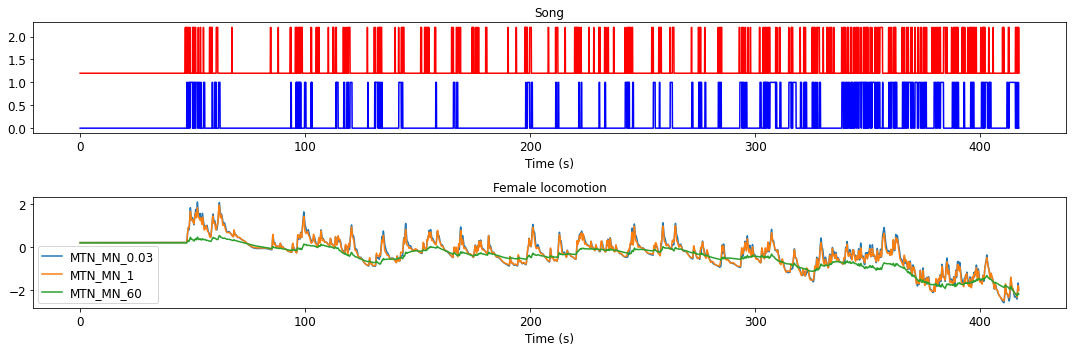

In [14]:
for ctr, df_tr_lin in enumerate(df_tr_lins[:5]):
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
    t = df_tr_lin['T']
    axs[0].plot(t, df_tr_lin['S'], c='b')
    axs[0].plot(t, df_tr_lin['P'] + 1.2, c='r')
    axs[0].set_title('Song')
    
    for targ in TARGS:
        axs[1].plot(t, df_tr_lin[targ])
        
    axs[1].set_title('Female locomotion')
    axs[1].legend(TARGS)
    
    for ax in axs:
        set_plot(ax, x_label='Time (s)', font_size=12)